Let's load the libraries and start looking through the data.

In [1]:
%matplotlib inline

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

Read the historical datasets, making sure to only read .csv files via a filter

In [25]:
FILES = os.listdir('./')
FILES = list(filter(lambda f: f.endswith('.csv'), FILES))

Get datafiles for Jan 2020 and Jan 2021 to compare

In [39]:
data_set_2021 = pd.read_csv([e for e in FILES if e.find('Jan_2021') != -1][0])

In [40]:
data_set_2020 = pd.read_csv([e for e in FILES if e.find('Jan_2020') != -1][0])

In [152]:
data_set_2021.head()

,neighbourhood,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,Lambeth,Entire home/apt,89,2,192,2020-03-26,1.46,3,344
1,Islington,Private room,40,1,21,2020-02-22,0.17,2,364
2,Kensington and Chelsea,Entire home/apt,75,10,89,2020-03-16,0.66,1,189
3,Westminster,Entire home/apt,307,4,42,2019-11-02,0.35,15,240
4,Hammersmith and Fulham,Private room,150,3,0,NaN,NaN,2,364


In [43]:
data_set_2020 = data_set_2020.drop(columns=['id', 'name', 'host_id', 'host_name', 'neighbourhood_group', 'latitude', 'longitude'])
data_set_2021 = data_set_2021.drop(columns=['id', 'name', 'host_id', 'host_name', 'neighbourhood_group', 'latitude', 'longitude'])

Let's first find NaNs and impute data for these NaNs

In [170]:
full_columns = set(data_set_2021.loc[:,:].columns) - set(data_set_2021.loc[:, data_set_2021.isnull().any()].columns)
nan_columns_2020 = set(data_set_2020.columns[data_set_2020.isnull().mean() > 0])
nan_columns_2021 = set(data_set_2021.columns[data_set_2021.isnull().mean() > 0])
print(f'These columns have missing data: {nan_columns_2020} for the 2020 dataset and {nan_columns_2021} for 2021')

These columns have missing data: {'reviews_per_month', 'last_review'} for the 2020 dataset and {'reviews_per_month', 'last_review'} for 2021


It seems that missing data is only in the review section of the data. I would imagine that this is due to properties having no reviews, which means that I would impute the NaNs with 0s. 

In [171]:
for column in nan_columns_2020:
    data_set_2020[column] = data_set_2020[column].fillna(0)
    data_set_2021[column] = data_set_2021[column].fillna(0)

Let's first look at the data that we have. Is there a reduction in the total listings between Jan 2020 and Jan 2021.

In [51]:
print(f'There are {data_set_2020.shape[0] - data_set_2021.shape[0]} less listings in Jan 2021 compared to a year earlier.')
print(f'This is a percentage reduction of {((data_set_2020.shape[0] - data_set_2021.shape[0])/data_set_2020.shape[0]) * 100}%')

There are 9123 less listings in Jan 2021 compared to a year earlier.
This is a percentage reduction of 10.550601949831732%


Now lets have a look if there are differences in type of accomodation offered and neighbourhoods

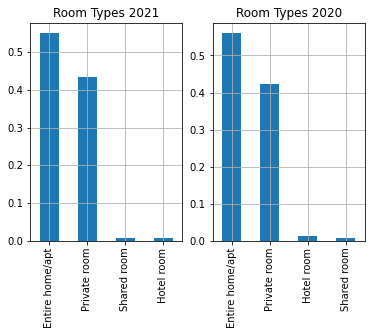

In [60]:
plt.subplot(121)
(data_set_2021.room_type.value_counts()/data_set_2021.shape[0]).plot(kind="bar");
plt.title("Room Types 2021");
plt.grid()
plt.subplot(122)
(data_set_2020.room_type.value_counts()/data_set_2020.shape[0]).plot(kind="bar");
plt.title("Room Types 2020");
plt.grid()

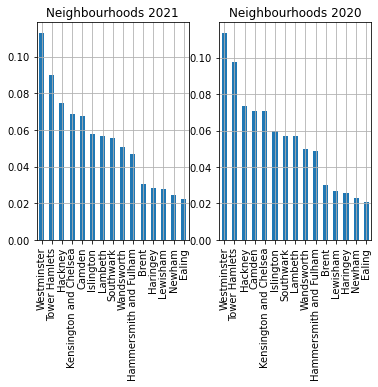

In [65]:
plt.subplot(121)
(data_set_2021.neighbourhood.value_counts()[:15]/data_set_2021.shape[0]).plot(kind="bar");
plt.title("Neighbourhoods 2021");
plt.grid()
plt.subplot(122)
(data_set_2020.neighbourhood.value_counts()[:15]/data_set_2020.shape[0]).plot(kind="bar");
plt.title("Neighbourhoods 2020");
plt.grid()

It looks like both the type and location of the offered accomodations have not changed dramatically over the course of 1 year between January 2020 and January 2021.

        Now let's look at the occupancy and availability

In [81]:
data_set_2020.groupby(['room_type']).mean()['reviews_per_month'].sort_index()

room_type
Entire home/apt    0.809616
Hotel room         0.851848
Private room       1.037548
Shared room        0.794643
Name: reviews_per_month, dtype: float64

In [80]:
data_set_2021.groupby(['room_type']).mean()['reviews_per_month'].sort_index()

room_type
Entire home/apt    0.390338
Hotel room         0.467452
Private room       0.464382
Shared room        0.367353
Name: reviews_per_month, dtype: float64

In [71]:
print(f"Average number of reviews of the different accomodation types for 2020 are: {data_set_2020.groupby(['room_type']).mean()['reviews_per_month'].sort_values()}")

Average number of reviews of the different accomodation types for 2020 are: room_type
Shared room        0.794643
Entire home/apt    0.809616
Hotel room         0.851848
Private room       1.037548
Name: reviews_per_month, dtype: float64


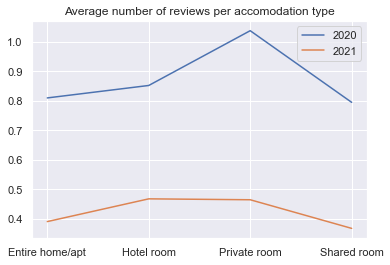

In [82]:
plt.plot(data_set_2020.groupby(['room_type']).mean()['reviews_per_month'].sort_index(), label='2020')
plt.plot(data_set_2021.groupby(['room_type']).mean()['reviews_per_month'].sort_index(), label='2021')
plt.title('Average number of reviews per accomodation type')
plt.legend()

Text(0.5, 1.0, 'Jan 2021 Data')

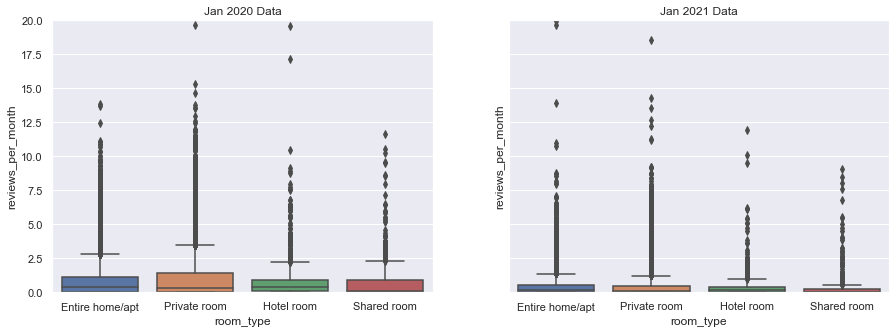

In [70]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
sns.boxplot(ax = axes[0], x="room_type", y="reviews_per_month", data=data_set_2020)
axes[0].set_title('Jan 2020 Data')
axes[0].set_ylim([0, 20])
sns.boxplot(ax = axes[1], x="room_type", y="reviews_per_month", data=data_set_2021)
axes[1].set_title('Jan 2021 Data')

Using the reviews to estimate occupancy (the same method for esitmating occupancy as Airbnb's "San Francisco Model") we can see that occupancy has fallen with about 50% between Jan 2020 and Jan 2021, while availability is on average around 8% larger in 2021. Let's see if the highly reviewed places are seeing the same drop in occupancy.

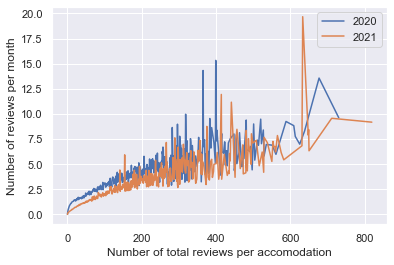

In [85]:
plt.plot(data_set_2020.groupby(['number_of_reviews']).mean()['reviews_per_month'].sort_index(), label='2020')
plt.plot(data_set_2021.groupby(['number_of_reviews']).mean()['reviews_per_month'].sort_index(), label='2021')
plt.xlabel('Number of total reviews per accomodation')
plt.ylabel('Number of reviews per month')

plt.legend()

We can see a slight shift in people booking higher reviewed accomodations more in 2021, compared to 2020, but how do the occupancy relate to the total reviews per accomodation.

In [115]:
print(f"We take the high reviewed properties as those whose review counts are larger than the \
        mean + 1 std of the number of reviews, for 2020 this number is: \
        {data_set_2020['number_of_reviews'].mean() + data_set_2020['number_of_reviews'].std()} \
        and for 2021 - {data_set_2021['number_of_reviews'].mean() + data_set_2021['number_of_reviews'].std()}")

We take the high reviewed properties as those whose review counts are larger than the         mean + 1 std of the number of reviews, for 2020 this number is:         54.61714087069369         and for 2021 - 50.71210270108489


In [118]:
df_2020_highreview = data_set_2020[data_set_2020['number_of_reviews'] > (data_set_2020['number_of_reviews'].mean() + 
                                  data_set_2020['number_of_reviews'].std())]
df_2021_highreview = data_set_2021[data_set_2021['number_of_reviews'] > (data_set_2021['number_of_reviews'].mean() + 
                                  data_set_2021['number_of_reviews'].std())]

In [126]:
print('Data for 2020 for highly reviewed properties:')
print(df_2020_highreview.groupby(['room_type']).mean()['reviews_per_month'].sort_values())
print('Data for 2021 for highly reviewed properties:')
print(df_2021_highreview.groupby(['room_type']).mean()['reviews_per_month'].sort_values())

Data for 2020 for highly reviewed properties:
room_type
Entire home/apt    2.326897
Private room       3.362170
Shared room        4.389038
Hotel room         4.810185
Name: reviews_per_month, dtype: float64
Data for 2021 for highly reviewed properties:
room_type
Entire home/apt    1.702541
Private room       2.377570
Shared room        3.381842
Hotel room         3.734286
Name: reviews_per_month, dtype: float64


From this analysis we can see that there is a drop in reviews - and thus occupancy for the highly reviewed properties, but the drop is lower than that for the general accomodations - we notice about 25% drop in these cases.

 Let's check the final question - is there a reduction of price in the year between Jan 2020 and Jan 2021. 

Text(0.5, 1.0, 'Jan 2021 Data')

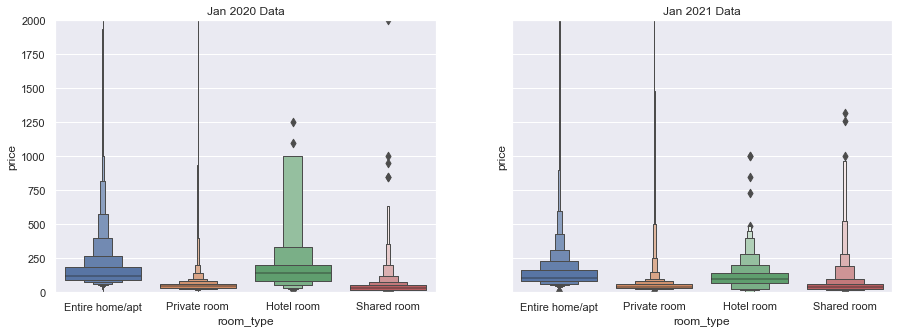

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
sns.boxenplot(ax = axes[0], x="room_type", y="price", data=data_set_2020)
axes[0].set_title('Jan 2020 Data')
axes[0].set_ylim([0, 2000])
sns.boxenplot(ax = axes[1], x="room_type", y="price", data=data_set_2021)
axes[1].set_title('Jan 2021 Data')

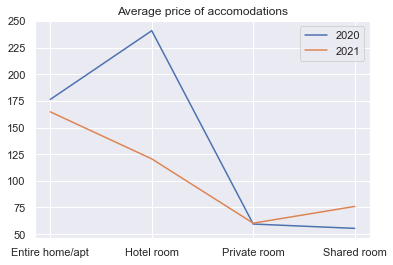

In [83]:

plt.plot(data_set_2020.groupby(['room_type']).mean()['price'].sort_index(), label='2020')
plt.plot(data_set_2021.groupby(['room_type']).mean()['price'].sort_index(), label='2021')
plt.title('Average price of accomodations')
plt.legend()

At least from the average of the price per accomodation type we can see that apart from hotels the average cost of the accomodations has not reduced, but rather has increased in the year between Jan 2020 and Jan 2021. Let's see if this correlates with the high rated properties.

In [59]:
print('Data for 2020 for highly reviewed properties:')
print(df_2020_highreview.groupby(['room_type']).mean()['price'].sort_values())
print('Data for 2021 for highly reviewed properties:')
print(df_2021_highreview.groupby(['room_type']).mean()['price'].sort_values())

Data for 2020 for highly reviewed properties:
room_type
Shared room         24.134615
Private room        50.651966
Entire home/apt    134.223321
Hotel room         216.074074
Name: price, dtype: float64
Data for 2021 for highly reviewed properties:
room_type
Private room        46.591930
Shared room         54.078947
Hotel room          66.114286
Entire home/apt    141.400000
Name: price, dtype: float64


Text(0.5, 1.0, 'Jan 2021 Data')

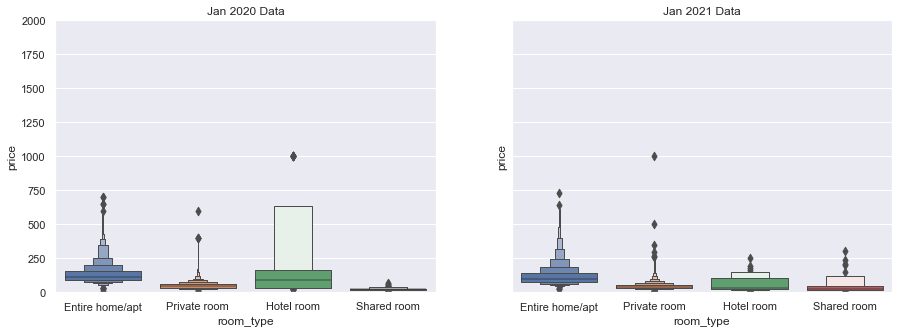

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
sns.boxenplot(ax = axes[0], x="room_type", y="price", data=df_2020_highreview)
axes[0].set_title('Jan 2020 Data')
axes[0].set_ylim([0, 2000])
sns.boxenplot(ax = axes[1], x="room_type", y="price", data=df_2021_highreview)
axes[1].set_title('Jan 2021 Data')

So it looks like the prices for shared rooms went up about 100%, while the hotel proces went down by 3 times. This can be explained by the fact that during the pandemic hotels were closed and/or have reduced prices to attract more clients. Let's look if these numbers are correlated with an increased minimum stay.

<AxesSubplot:>

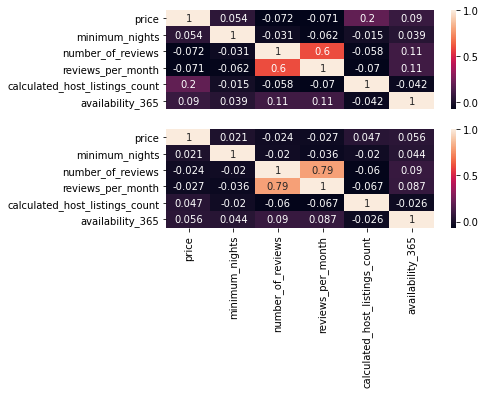

In [209]:
plt.subplot(211)
sns.heatmap(data_set_2020.corr(), annot=True, xticklabels=False)
plt.subplot(212)
sns.heatmap(data_set_2021.corr(), annot=True)

Text(0.5, 1.0, '2021 Data')

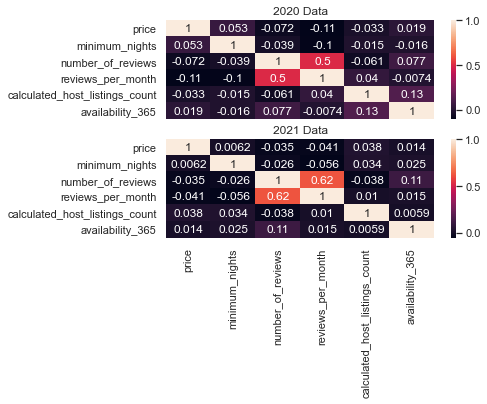

In [62]:
plt.subplot(211)
sns.heatmap(df_2020_highreview.corr(), annot=True, xticklabels=False)
plt.title('2020 Data')
plt.subplot(212)
sns.heatmap(df_2021_highreview.corr(), annot=True)
plt.title('2021 Data')

2020 Data:
2021 Data:


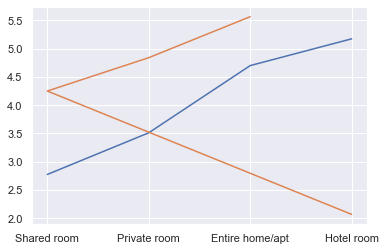

In [57]:
print('2020 Data:')
plt.plot(data_set_2020.groupby(['room_type']).mean()['minimum_nights'].sort_values())
print('2021 Data:')
plt.plot(data_set_2021.groupby(['room_type']).mean()['minimum_nights'].sort_values())


So it looks like that there was a considerable increase of minimum nights for shared rooms and a considerable decrease of minimum night requirement for the hotel, that can explain the difference in prices. Let's create a new column that would take the price offset with the minimum night requirements. 


In [ ]:
sns.catplot(x="room_type", y="price",
               data=data_set_2020, kind="box")

Data for 2020 for highly reviewed properties:
Data for 2021 for highly reviewed properties:


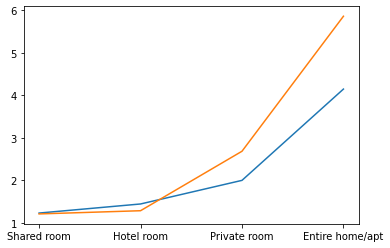

In [200]:
print('Data for 2020 for highly reviewed properties:')
plt.plot(df_2020_highreview.groupby(['room_type']).mean()['minimum_nights'].sort_values())
print('Data for 2021 for highly reviewed properties:')
plt.plot(df_2021_highreview.groupby(['room_type']).mean()['minimum_nights'].sort_values())